## Теоретические выкладки

In [168]:
from sympy import *

C11, C12, C16, C22, C26, C66 = symbols('C11, C12, C16, C22, C26, C66')
C = Matrix([[C11, C12, C16],
           [C12, C22, C26],
           [C16, C26, C66]])
print("Matrix of conversion tensor, which connects tension (σ) and extensions (ε)")
display(C)
sigx, sigy, sigz = symbols('sigma_x sigma_y sigma_z')
sig = Matrix([sigx, sigy, sigz])
print("Vector of tension (σ):")
display(sig)
epsx, epsy, epsz = symbols('epsilon_x epsilon_y epsilon_z')
eps = Matrix([epsx, epsy, epsz])
print("Vector of extension (ε):")
display(eps)
Tensor_equation = Eq(sig, C*eps)
print("The matrix equation binding tension and extension")
display(Tensor_equation)
T = symbols('T')
init_printing(use_unicode=True)
nabla = symbols('U+2207')
display(nabla)
print("The equation of equilibrium is such:")
rho = Symbol('rho')
print("Solving all tensor equations we finish with matrixes Ax and Ay:")
A_x = Matrix([[0,    0,      -1/rho, 0, 0     ],
              [0,    0,      0,      0, -1/rho],
              [-C11, -C12/2, 0,      0, 0     ],
              [-C12, -C22/2, 0,      0, 0     ],
              [-C16, -C26/2, 0,      0, 0,    ]])
print("Ax =")
display(A_x)
A_y = Matrix([[0,      0,    0, 0,      -1/rho],
              [0,      0,    0, -1/rho, 0     ],
              [-C16/2, -C12, 0, 0,      0     ],
              [-C26/2, -C22, 0, 0,      0     ],
              [-C66/2, -C26, 0, 0,      0,    ]])
print("Ay =")
display(A_y)


Matrix of conversion tensor, which connects tension (σ) and extensions (ε)


⎡C₁₁  C₁₂  C₁₆⎤
⎢             ⎥
⎢C₁₂  C₂₂  C₂₆⎥
⎢             ⎥
⎣C₁₆  C₂₆  C₆₆⎦

Vector of tension (σ):


⎡σₓ ⎤
⎢   ⎥
⎢σ_y⎥
⎢   ⎥
⎣σ_z⎦

Vector of extension (ε):


⎡εₓ ⎤
⎢   ⎥
⎢ε_y⎥
⎢   ⎥
⎣ε_z⎦

The matrix equation binding tension and extension


⎡σₓ ⎤   ⎡C₁₁⋅εₓ + C₁₂⋅ε_y + C₁₆⋅ε_z⎤
⎢   ⎥   ⎢                          ⎥
⎢σ_y⎥ = ⎢C₁₂⋅εₓ + C₂₂⋅ε_y + C₂₆⋅ε_z⎥
⎢   ⎥   ⎢                          ⎥
⎣σ_z⎦   ⎣C₁₆⋅εₓ + C₂₆⋅ε_y + C₆₆⋅ε_z⎦

The equation of equilibrium is such:
Solving all tensor equations we finish with matrixes Ax and Ay:
Ax =


⎡             -1         ⎤
⎢ 0      0    ───  0   0 ⎥
⎢              ρ         ⎥
⎢                        ⎥
⎢                     -1 ⎥
⎢ 0      0     0   0  ───⎥
⎢                      ρ ⎥
⎢                        ⎥
⎢      -C₁₂              ⎥
⎢-C₁₁  ─────   0   0   0 ⎥
⎢        2               ⎥
⎢                        ⎥
⎢      -C₂₂              ⎥
⎢-C₁₂  ─────   0   0   0 ⎥
⎢        2               ⎥
⎢                        ⎥
⎢      -C₂₆              ⎥
⎢-C₁₆  ─────   0   0   0 ⎥
⎣        2               ⎦

Ay =


⎡                     -1 ⎤
⎢  0     0    0   0   ───⎥
⎢                      ρ ⎥
⎢                        ⎥
⎢                -1      ⎥
⎢  0     0    0  ───   0 ⎥
⎢                 ρ      ⎥
⎢                        ⎥
⎢-C₁₆                    ⎥
⎢─────  -C₁₂  0   0    0 ⎥
⎢  2                     ⎥
⎢                        ⎥
⎢-C₂₆                    ⎥
⎢─────  -C₂₂  0   0    0 ⎥
⎢  2                     ⎥
⎢                        ⎥
⎢-C₆₆                    ⎥
⎢─────  -C₂₆  0   0    0 ⎥
⎣  2                     ⎦

## Библиотеки

In [97]:
import numpy as np
import matplotlib.pyplot as plt

## Функции

In [109]:
def fill_C(): #Заполнить сетку ненулевыми лямбдами
    C11 = 12.98344389516936
    C12 = 2.76656283641825
    C16 = 5.00630996992227
    C22 = 79.21121100901908
    C26 = 4.88188079023485
    C66 = 13.05325089362048
    C = np.array([(C11, C12, C16),
                  (C12, C22, C26),
                  (C16, C26, C66)])
    return C
            
def Omega(q):
    vx, vy, sxx, sxy = q
    return (np.sqrt(mu * rho) / 2.0 * vy + sxy / 2.0,
            -np.sqrt(mu * rho) / 2.0 * vy + sxy / 2.0,
            np.sqrt(rho * (lam + 2.0 * mu)) / 2.0 * vx + sxx / 2.0,
            -np.sqrt(rho * (lam + 2.0 * mu)) / 2.0 * vx + sxx / 2.0
           )

## Переменные

In [110]:
L = 1 # масштаб координатных осей
M = 51 # количество узлов вдоль оси
#C =  np.ones((3, 3)) # Сетка лямбд
C = fill_C()
print(C)
h = L / M # шаг по координате, h
T = 1.5 * L / abs(np.max(C)) # 1 полный оборот начального возмущения
dt = 0.4 * h / abs(np.max(C)) # коэффициент должен быть меньше единицы
step_1 = C * dt / h # комбинация коэффициентов при шаге первого порядка
data_current = np.zeros((M, M), dtype=[('q', np.float64)])
data_next = np.zeros((M, M), dtype=[('q', np.float64)])

[[12.9834439   2.76656284  5.00630997]
 [ 2.76656284 79.21121101  4.88188079]
 [ 5.00630997  4.88188079 13.05325089]]


## Начальные условия (актуально до ввода источника)

In [94]:
for j in range(M):
    for i in range(M):
        if (i > M / 3.0) and (i < 2.0 * M / 3.0) and (j > M / 3.0) and (j < 2.0 * M / 3.0):
            data_current[j, i]['q'] = 1.0

## Расчёт

In [95]:
for k in range(int(T / dt)):
    # Шаг по X
    for j in range(M):
        for i in range(M):
            if i == 0: # периодические граничные условия
                data_next[j, i]['q'] = data_current[j, i]['q'] - C[j, i] * dt / h * (data_current[j, i]['q'] - data_current[j, M - 1]['q'])
            data_next[j, i]['q'] = data_current[j, i]['q'] - C[j, i] * dt / h * (data_current[j, i]['q'] - data_current[j, i - 1]['q'])
    # Шаг по Y
    for j in range(M):
        for i in range(M):
            if j == 0: # периодические граничные условия
                data_current[j, i]['q'] = data_next[j, i]['q'] - C[j, i] * dt / h * (data_next[j, i]['q'] - data_next[M - 1, i]['q'])
            data_current[j, i]['q'] = data_next[j, i]['q'] - C[j, i] * dt / h * (data_next[j, i]['q'] - data_next[j - 1, i]['q'])

## Визуальное отображение

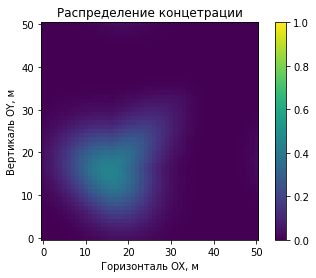

In [96]:
fig, ax = plt.subplots()
ax.set_title('Распределение концетрации')
_ = ax.set_xlabel('Горизонталь OX, м')
_ = ax.set_ylabel('Вертикаль OY, м')
img = ax.imshow(data_current['q'], vmin = 0, vmax = 1, origin = 'lower')
_ = fig.colorbar(img)